# **1. 메타모픽 테스트: Tensorflow**

## **1.1 MNIST 데이터셋**

- **회전 변환(Rotation)**: 이미지를 약간 회전시켜도 동일한 숫자로 인식되어야 함
- **밝기 변화(Brightness)**: 이미지의 밝기를 변경해도 동일한 숫자로 인식되어야 함

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [55]:
import tensorflow as tf

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [57]:
from scipy.ndimage import rotate

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
# 한글폰트 설치하기 위해 필요한 모듈
import matplotlib.font_manager as fm

In [60]:
# 나눔바른고딕 폰트 설치 - 런타임 연결이 다시 될 때마다 다시 폰트를 설치해야 한글이 보인다.
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [61]:
# 폰트 적용
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rcParams['font.family'] = "NanumBarunGothic"

In [62]:
# 마이너스(음수)부호 설정
plt.rc("axes", unicode_minus = False)

In [63]:
# MNIST 데이터셋 로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [64]:
# 데이터 전처리
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

In [65]:
# 간단한 CNN 모델 생성
def create_mnist_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [66]:
# 모델 학습 (실제 테스트 시에는 epochs를 늘려주세요)
model = create_mnist_model()
model.fit(x_train, y_train, batch_size=128, epochs=1, validation_split=0.1)

422/422 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.8437 - loss: 0.5253 - val_accuracy: 0.9802 - val_loss: 0.0670


In [67]:
# 메타모픽 관계 1: 이미지 회전
def rotate_image(image, angle):
    # 이미지 형태 변환 (채널 차원 제거)
    image = np.squeeze(image)
    rotated = rotate(image, angle, reshape=False)
    # 회전 후 값의 범위가 [0, 1]을 벗어날 수 있으므로 클리핑
    rotated = np.clip(rotated, 0, 1)
    # 채널 차원 다시 추가
    return rotated.reshape(28, 28, 1)

In [68]:
# 메타모픽 관계 2: 이미지 밝기 변경
def change_brightness(image, factor):
    # 밝기 변경 (factor > 1: 밝게, factor < 1: 어둡게)
    brightened = image * factor
    # 값의 범위가 [0, 1]을 벗어날 수 있으므로 클리핑
    return np.clip(brightened, 0, 1)

In [69]:
# 메타모픽 테스트 함수
def metamorphic_test_mnist(model, test_images, test_labels, num_samples=100):
    # 테스트할 샘플 수 제한
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    test_images = test_images[indices]
    test_labels = test_labels[indices]

    # 원본 이미지에 대한 예측
    original_predictions = np.argmax(model.predict(test_images), axis=1)

    # 메타모픽 관계 1: 작은 각도 회전 (10도): 각도가 커질 수록 정확도는 떨어질 수 있음
    rotated_images = np.array([rotate_image(img, 10) for img in test_images])
    rotated_predictions = np.argmax(model.predict(rotated_images), axis=1)
    rotation_consistency = np.mean(original_predictions == rotated_predictions)

    # 메타모픽 관계 2: 밝기 변경 (20% 밝게)
    brightened_images = np.array([change_brightness(img, 1.2) for img in test_images])
    brightened_predictions = np.argmax(model.predict(brightened_images), axis=1)
    brightness_consistency = np.mean(original_predictions == brightened_predictions)

    print("=== MNIST 메타모픽 테스트 결과 ===")
    print(f"회전 변환 일관성: {rotation_consistency:.4f}")
    print(f"밝기 변경 일관성: {brightness_consistency:.4f}")

    # 결과 시각화 (일부 샘플만)
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        # 원본 이미지
        axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f"원본: {original_predictions[i]}")

        # 회전 이미지
        axes[1, i].imshow(rotated_images[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title(f"회전: {rotated_predictions[i]}")

        # 밝기 변경 이미지
        axes[2, i].imshow(brightened_images[i].reshape(28, 28), cmap='gray')
        axes[2, i].set_title(f"밝기 변경: {brightened_predictions[i]}")

    plt.tight_layout()
    plt.show()

    return rotation_consistency, brightness_consistency

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
=== MNIST 메타모픽 테스트 결과 ===
회전 변환 일관성: 0.9700
밝기 변경 일관성: 1.0000


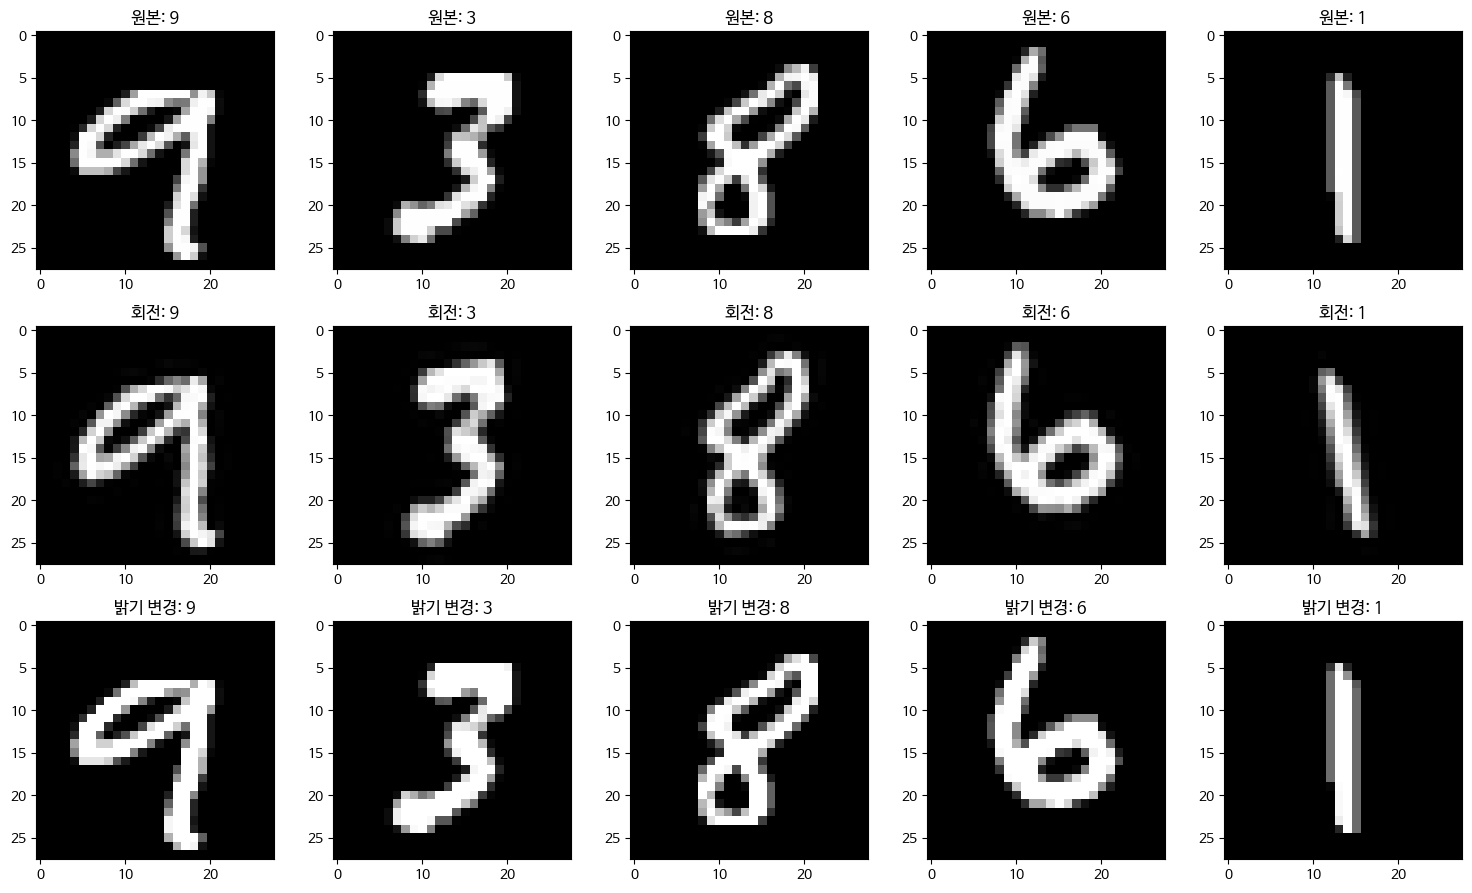

In [70]:
# MNIST 메타모픽 테스트 실행
rotation_result, brightness_result = metamorphic_test_mnist(model, x_test, y_test)

## 1.2 **HouseSales 데이터셋**

- **특성 스케일링(Feature Scaling)**: 입력 특성의 스케일을 변경해도 예측 결과는 동일해야 함
- **단위 변환(Unit Conversion)**: 예를 들어 평방피트를 평방미터로 변환해도 예측 결과는 비례 관계를 유지해야 함

In [71]:
# HouseSales 데이터 로드 함수
def load_house_data(file_path='https://raw.githubusercontent.com/SkyLectures/LectureMaterials/refs/heads/main/datasets/S03-10-02-02_01-kc_house_data.csv'):
    # 데이터 읽기
    df = pd.read_csv(file_path)

    # 필요없는 컬럼 제거
    df = df.drop(['id', 'date'], axis=1)

    # 결측치 처리
    df = df.dropna()

    # 이상치 확인 및 제거
    q_low = df['price'].quantile(0.01)
    q_high = df['price'].quantile(0.99)
    df = df[(df['price'] > q_low) & (df['price'] < q_high)]

    # 특성(X)과 타겟(y) 분리
    X = df.drop('price', axis=1)
    y = df['price']

    # 학습 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

    # 특성 스케일링 (표준화)
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    return X_train, X_test, y_train, y_test, X.columns, scaler_X

In [72]:
# 간단한 회귀 모델 생성
def create_house_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)  # 회귀 문제이므로 출력층은 하나의 노드
    ])

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    return model

In [73]:
# HouseSales 데이터셋 로드
X_train, X_test, y_train, y_test, feature_names, scaler_X = load_house_data()

In [74]:
# 모델 학습 (실제 테스트 시에는 epochs를 늘려주세요)
house_model = create_house_model(X_train.shape[1])
house_model.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

Epoch 1/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 352965525504.0000 - mae: 522737.3750 - val_loss: 335060434944.0000 - val_mae: 507069.4375
Epoch 2/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 332464324608.0000 - mae: 506445.3438 - val_loss: 260739121152.0000 - val_mae: 447370.0938
Epoch 3/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 234126540800.0000 - mae: 424004.8125 - val_loss: 150514417664.0000 - val_mae: 328425.1875
Epoch 4/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 131869057024.0000 - mae: 300894.6875 - val_loss: 86333317120.0000 - val_mae: 233037.3906
Epoch 5/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 79673876480.0000 - mae: 221477.6094 - val_loss: 65252401152.0000 - val_mae: 198913.0312


In [75]:
# 메타모픽 관계 1: 특성 스케일링 변환
def scale_features(X, feature_indices, scaling_factor):
    X_scaled = X.copy()
    for idx in feature_indices:
        X_scaled[:, idx] = X_scaled[:, idx] * scaling_factor
    return X_scaled

In [76]:
# 메타모픽 관계 2: 단위 변환 (평방피트 -> 평방미터)
def convert_sqft_to_sqm(X, sqft_feature_idx):
    # 평방피트를 평방미터로 변환 (1 평방피트 = 0.092903 평방미터)
    X_converted = X.copy()
    X_converted[:, sqft_feature_idx] = X_converted[:, sqft_feature_idx] * 0.092903
    return X_converted

In [77]:
# 메타모픽 테스트 함수
def metamorphic_test_house(model, X_test, y_test, feature_names, scaler_X, num_samples=100):
    # 테스트할 샘플 수 제한
    # 안전하게 인덱스 생성: 범위를 벗어나지 않도록 처리
    total_samples = len(X_test)
    num_samples = min(num_samples, total_samples)  # 데이터셋 크기보다 크지 않도록

    # 랜덤 인덱스 생성 (중복 없이)
    indices = np.random.choice(range(total_samples), num_samples, replace=False)

    # 데이터 추출 (인덱스 유효성 검사)
    X_test_sample = X_test[indices]
    y_test_sample = y_test[indices] if isinstance(y_test, np.ndarray) else y_test.iloc[indices]

    # 원본 데이터에 대한 예측
    original_predictions = model.predict(X_test_sample).flatten()

    # --------------------------------------------------------------------------
    # 메타모픽 관계 1: 특성 스케일링 (sqft_living 특성을 2배로 스케일링)
    # --------------------------------------------------------------------------
    # sqft_living 특성의 인덱스 찾기
    try:
        sqft_living_idx = list(feature_names).index('sqft_living')
    except ValueError:
        # 특성 이름이 정확히 일치하지 않는 경우, 근사값 사용
        sqft_living_idx = 2  # 일반적으로 sqft_living은 앞쪽 컬럼에 위치

    # 스케일링된 데이터 생성
    scaled_X = scale_features(X_test_sample, [sqft_living_idx], 2.0)

    # 스케일링된 데이터를 다시 원래 스케일로 변환 (스케일러의 역변환 적용)
    # 스케일러에 맞게 데이터 역변환 (실제 구현 시 주의 필요)
    # 여기서는 간단한 예시를 위해 직접 역스케일링
    scaled_X[:, sqft_living_idx] = scaled_X[:, sqft_living_idx] / 2.0

    # 변환된 데이터에 대한 예측
    scaled_predictions = model.predict(scaled_X).flatten()

    # --------------------------------------------------------------------------
    # 메타모픽 관계 2: 단위 변환
    # --------------------------------------------------------------------------
    # 평방피트를 평방미터로 변환
    converted_X = convert_sqft_to_sqm(X_test_sample, sqft_living_idx)

    # 변환 후 다시 원래 단위로 복원 (모델이 원래 단위로 학습되었으므로)
    converted_X[:, sqft_living_idx] = converted_X[:, sqft_living_idx] / 0.092903

    # 변환된 데이터에 대한 예측
    converted_predictions = model.predict(converted_X).flatten()

    # --------------------------------------------------------------------------
    # 메타모픽 관계 검증
    # --------------------------------------------------------------------------
    # 1. 스케일링 관계: 원본 예측과 스케일링 후 예측이 거의 동일해야 함
    scaling_diff = np.abs(original_predictions - scaled_predictions)
    scaling_relation_satisfied = np.mean(scaling_diff < 1e-5)  # 허용 오차 설정

    # 2. 단위 변환 관계: 원본 예측과 단위 변환 후 예측이 거의 동일해야 함
    conversion_diff = np.abs(original_predictions - converted_predictions)
    conversion_relation_satisfied = np.mean(conversion_diff < 1e-5)  # 허용 오차 설정

    print("=== HouseSales 메타모픽 테스트 결과 ===")
    print(f"특성 스케일링 변환 일관성: {scaling_relation_satisfied:.4f}")
    print(f"단위 변환 일관성: {conversion_relation_satisfied:.4f}")

    # --------------------------------------------------------------------------
    # 결과 시각화
    # --------------------------------------------------------------------------
    plt.figure(figsize=(12, 6))

    # 원본 vs 스케일링 변환 예측
    plt.subplot(1, 2, 1)
    plt.scatter(original_predictions, scaled_predictions)
    plt.plot([min(original_predictions), max(original_predictions)],
             [min(original_predictions), max(original_predictions)], 'r--')
    plt.xlabel('원본 예측')
    plt.ylabel('스케일링 변환 후 예측')
    plt.title('특성 스케일링 메타모픽 관계')

    # 원본 vs 단위 변환 예측
    plt.subplot(1, 2, 2)
    plt.scatter(original_predictions, converted_predictions)
    plt.plot([min(original_predictions), max(original_predictions)],
             [min(original_predictions), max(original_predictions)], 'r--')
    plt.xlabel('원본 예측')
    plt.ylabel('단위 변환 후 예측')
    plt.title('단위 변환 메타모픽 관계')

    plt.tight_layout()
    plt.show()

    return scaling_relation_satisfied, conversion_relation_satisfied

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
=== HouseSales 메타모픽 테스트 결과 ===
특성 스케일링 변환 일관성: 1.0000
단위 변환 일관성: 1.0000


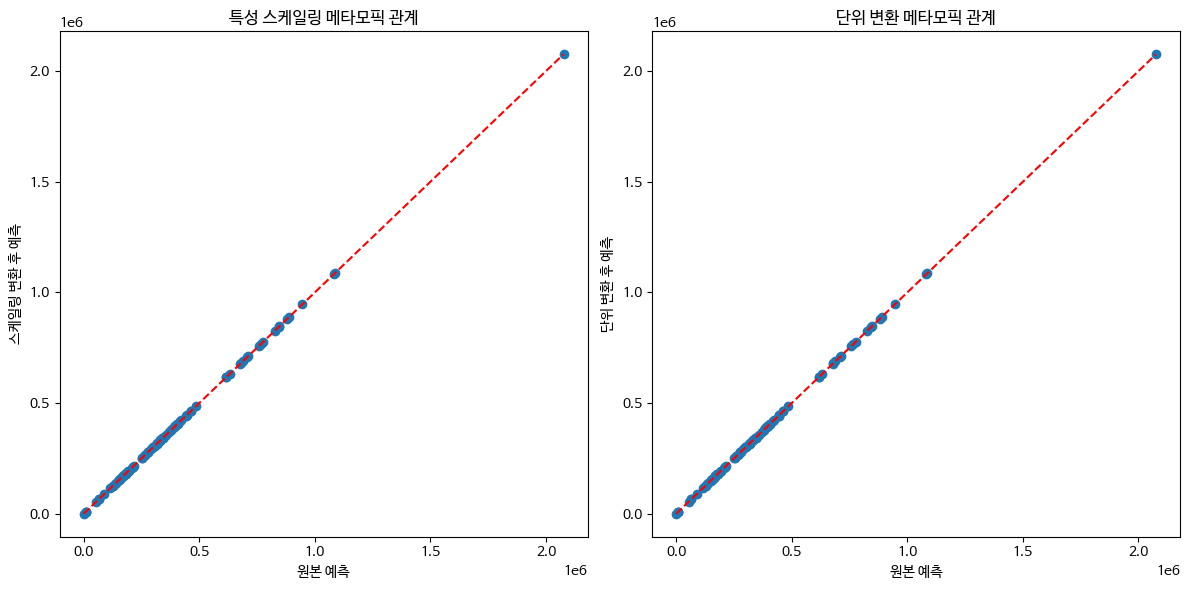

In [78]:
# HouseSales 메타모픽 테스트 실행
scaling_result, conversion_result = metamorphic_test_house(house_model, X_test, y_test, feature_names, scaler_X)

## **1.3 결과 종합 및 분석**

In [79]:
def analyze_metamorphic_test_results(mnist_results, house_results):
    print("\n=== 메타모픽 테스트 종합 결과 ===")

    # MNIST 결과 분석
    rotation_result, brightness_result = mnist_results
    print("MNIST 데이터셋:")
    print(f"  - 회전 변환 일관성: {rotation_result:.4f}")
    print(f"  - 밝기 변경 일관성: {brightness_result:.4f}")

    if rotation_result >= 0.95 and brightness_result >= 0.95:
        print("  ✓ MNIST 모델은 메타모픽 테스트를 통과했습니다!")
    elif rotation_result >= 0.8 and brightness_result >= 0.8:
        print("  △ MNIST 모델은 메타모픽 테스트를 부분적으로 통과했습니다.")
    else:
        print("  ✗ MNIST 모델은 메타모픽 테스트를 통과하지 못했습니다.")

    # HouseSales 결과 분석
    scaling_result, conversion_result = house_results
    print("\nHouseSales 데이터셋:")
    print(f"  - 특성 스케일링 일관성: {scaling_result:.4f}")
    print(f"  - 단위 변환 일관성: {conversion_result:.4f}")

    if scaling_result >= 0.95 and conversion_result >= 0.95:
        print("  ✓ HouseSales 모델은 메타모픽 테스트를 통과했습니다!")
    elif scaling_result >= 0.8 and conversion_result >= 0.8:
        print("  △ HouseSales 모델은 메타모픽 테스트를 부분적으로 통과했습니다.")
    else:
        print("  ✗ HouseSales 모델은 메타모픽 테스트를 통과하지 못했습니다.")

    print("\n메타모픽 테스트 결과 해석:")
    print("1. 일관성 점수가 높을수록 모델이 해당 변환에 강인함을 의미합니다.")
    print("2. 일관성 점수가 낮다면 모델이 해당 변환에 취약하며, 추가 학습이나 데이터 증강이 필요할 수 있습니다.")
    print("3. 메타모픽 테스트는 테스트 오라클 문제를 해결하는 효과적인 방법으로, 모델의 신뢰성을 검증합니다.")

In [80]:
# 종합 결과 분석
analyze_metamorphic_test_results(
    mnist_results=(rotation_result, brightness_result),
    house_results=(scaling_result, conversion_result)
)


=== 메타모픽 테스트 종합 결과 ===
MNIST 데이터셋:
  - 회전 변환 일관성: 0.9700
  - 밝기 변경 일관성: 1.0000
  ✓ MNIST 모델은 메타모픽 테스트를 통과했습니다!

HouseSales 데이터셋:
  - 특성 스케일링 일관성: 1.0000
  - 단위 변환 일관성: 1.0000
  ✓ HouseSales 모델은 메타모픽 테스트를 통과했습니다!

메타모픽 테스트 결과 해석:
1. 일관성 점수가 높을수록 모델이 해당 변환에 강인함을 의미합니다.
2. 일관성 점수가 낮다면 모델이 해당 변환에 취약하며, 추가 학습이나 데이터 증강이 필요할 수 있습니다.
3. 메타모픽 테스트는 테스트 오라클 문제를 해결하는 효과적인 방법으로, 모델의 신뢰성을 검증합니다.


# **2. 메타모픽 테스트: PyTorch**

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [85]:
from scipy.ndimage import rotate

In [86]:
# 시드 설정
torch.manual_seed(6)
np.random.seed(6)

In [87]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 디바이스: {device}')

사용 중인 디바이스: cpu


## **2.1 MNIST 데이터셋**

In [88]:
# CNN 모델 정의
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [89]:
# MNIST 데이터셋 로드 및 전처리
def load_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return test_dataset, test_loader

In [90]:
# 메타모픽 관계 1: 이미지 회전
def rotate_image(image, angle):
    # PyTorch 텐서를 NumPy 배열로 변환
    image_np = image.squeeze().numpy()
    rotated = rotate(image_np, angle, reshape=False)
    rotated = np.clip(rotated, 0, 1)
    # NumPy 배열을 다시 PyTorch 텐서로 변환
    return torch.tensor(rotated).unsqueeze(0).float()

In [91]:
# 메타모픽 관계 2: 이미지 밝기 변경
def change_brightness(image, factor):
    # 밝기 변경
    brightened = image * factor
    # 값의 범위가 [0, 1]을 벗어날 수 있으므로 클리핑
    return torch.clamp(brightened, 0, 1)

In [92]:
# 모델 학습 (실제 테스트에서는 이 부분이 이미 완료되었다고 가정)
def train_mnist_model():
    # 간단한 학습 코드 (실제로는 더 복잡할 수 있음)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = MnistCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 간략화된 학습 (실제로는 더 많은 에포크 필요)
    for epoch in range(1):  # 실제로는 더 많은 에포크 사용
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/1], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    return model

In [93]:
# MNIST 메타모픽 테스트 함수
def metamorphic_test_mnist(model, test_loader, num_samples=100):
    model.eval()  # 평가 모드 설정

    # 테스트할 샘플 수 제한
    indices = np.random.choice(len(test_loader.dataset), num_samples, replace=False)

    original_predictions = []
    rotated_predictions = []
    brightened_predictions = []

    original_images = []
    rotated_images = []
    brightened_images = []

    labels = []

    with torch.no_grad():
        for idx in indices:
            # 원본 이미지 가져오기
            image, label = test_loader.dataset[idx]
            image = image.to(device)

            # 원본 이미지에 대한 예측
            output = model(image.unsqueeze(0))
            pred = output.argmax(dim=1).item()
            original_predictions.append(pred)

            # 메타모픽 관계 1: 작은 각도 회전 (5도)
            rotated = rotate_image(image.cpu(), 5).to(device)
            output_rotated = model(rotated.unsqueeze(0))
            pred_rotated = output_rotated.argmax(dim=1).item()
            rotated_predictions.append(pred_rotated)

            # 메타모픽 관계 2: 밝기 변경 (20% 밝게)
            brightened = change_brightness(image, 1.2)
            brightened = brightened.to(device)
            output_brightened = model(brightened.unsqueeze(0))
            pred_brightened = output_brightened.argmax(dim=1).item()
            brightened_predictions.append(pred_brightened)

            # 시각화를 위해 이미지 저장
            original_images.append(image.cpu())
            rotated_images.append(rotated.cpu().squeeze(0))
            brightened_images.append(brightened.cpu())
            labels.append(label)

    # 일관성 계산
    rotation_consistency = np.mean(np.array(original_predictions) == np.array(rotated_predictions))
    brightness_consistency = np.mean(np.array(original_predictions) == np.array(brightened_predictions))

    print("=== MNIST 메타모픽 테스트 결과 ===")
    print(f"회전 변환 일관성: {rotation_consistency:.4f}")
    print(f"밝기 변경 일관성: {brightness_consistency:.4f}")

    # 결과 시각화 (일부 샘플만)
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        # 원본 이미지
        axes[0, i].imshow(original_images[i].squeeze().numpy(), cmap='gray')
        axes[0, i].set_title(f"원본: {original_predictions[i]}")

        # 회전 이미지
        axes[1, i].imshow(rotated_images[i].squeeze().numpy(), cmap='gray')
        axes[1, i].set_title(f"회전: {rotated_predictions[i]}")

        # 밝기 변경 이미지
        axes[2, i].imshow(brightened_images[i].squeeze().numpy(), cmap='gray')
        axes[2, i].set_title(f"밝기 변경: {brightened_predictions[i]}")

    plt.tight_layout()
    plt.show()

    return rotation_consistency, brightness_consistency

MNIST 데이터셋 로드 중...
MNIST 모델 학습 또는 로드 중...
MNIST 메타모픽 테스트 실행 중...
=== MNIST 메타모픽 테스트 결과 ===
회전 변환 일관성: 0.9900
밝기 변경 일관성: 0.9800


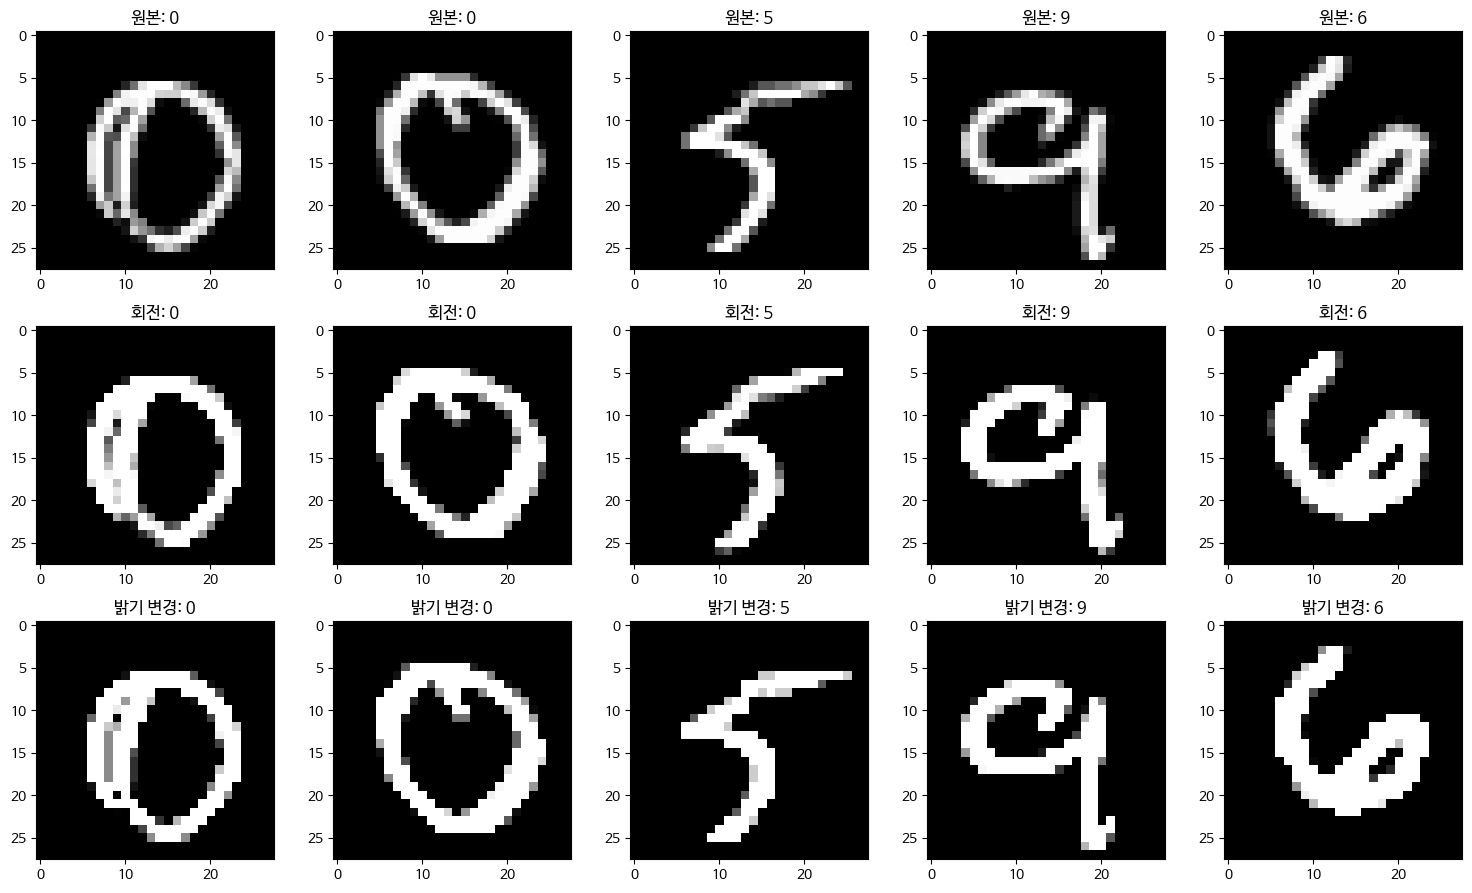

In [103]:
# MNIST 메타모픽 테스트

print("MNIST 데이터셋 로드 중...")
test_dataset, test_loader = load_mnist_data()

print("MNIST 모델 학습 또는 로드 중...")
# 실제 사용 시에는 학습된 모델을 로드하는 것이 좋습니다
try:
  model = MnistCNN().to(device)
  model.load_state_dict(torch.load('model_meta_morphic_mnist_cnn_pytorch.pth', map_location=device))
except:
  print("저장된 모델을 찾을 수 없어 새 모델을 학습합니다.")
  model = train_mnist_model()
  torch.save(model.state_dict(), 'model_meta_morphic_mnist_cnn_pytorch.pth')

print("MNIST 메타모픽 테스트 실행 중...")
mnist_results = metamorphic_test_mnist(model, test_loader)

## **2.2 HouseSales 데이터셋**

In [105]:
# HouseSales 데이터셋을 위한 모델 정의
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.layer4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.layer1(x)))
        x = self.relu(self.batch_norm2(self.layer2(x)))
        x = self.relu(self.batch_norm3(self.layer3(x)))
        x = self.layer4(x)
        return x

In [106]:
# HouseSales 데이터셋 로드 및 전처리
class HouseSalesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [107]:
def load_house_data(file_path='https://raw.githubusercontent.com/SkyLectures/LectureMaterials/refs/heads/main/datasets/S03-10-02-02_01-kc_house_data.csv'):
    # 데이터 읽기
    df = pd.read_csv(file_path)

    # 필요없는 컬럼 제거
    df = df.drop(['id', 'date'], axis=1)

    # 결측치 처리
    df = df.dropna()

    # 이상치 확인 및 제거
    q_low = df['price'].quantile(0.01)
    q_high = df['price'].quantile(0.99)
    df = df[(df['price'] > q_low) & (df['price'] < q_high)]

    # 특성(X)과 타겟(y) 분리
    X = df.drop('price', axis=1)
    y = df['price']

    # 학습 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

    # 특성 스케일링 (표준화)
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    # 타겟 변수도 스케일링
    scaler_y = StandardScaler()
    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    return X_train, X_test, y_train, y_test, X.columns, scaler_X, scaler_y

In [108]:
# 메타모픽 관계 1: 특성 스케일링 변환
def scale_features(X, feature_indices, scaling_factor):
    X_scaled = X.clone().detach()
    for idx in feature_indices:
        X_scaled[:, idx] = X_scaled[:, idx] * scaling_factor
    return X_scaled

In [109]:
# 메타모픽 관계 2: 단위 변환 (평방피트 -> 평방미터)
def convert_sqft_to_sqm(X, sqft_feature_idx):
    X_converted = X.clone().detach()
    X_converted[:, sqft_feature_idx] = X_converted[:, sqft_feature_idx] * 0.092903
    return X_converted

In [110]:
# HouseSales 메타모픽 테스트 함수
def metamorphic_test_house(model, X_test, y_test, feature_names, scaler_X, num_samples=100):
    model.eval()  # 평가 모드 설정

    # 테스트할 샘플 수 제한
    total_samples = len(X_test)
    num_samples = min(num_samples, total_samples)

    # 랜덤 인덱스 생성 (중복 없이)
    indices = np.random.choice(range(total_samples), num_samples, replace=False)

    # 데이터 추출
    X_test_sample = X_test[indices]
    X_test_tensor = torch.tensor(X_test_sample, dtype=torch.float32).to(device)

    # 원본 데이터에 대한 예측
    with torch.no_grad():
        original_predictions = model(X_test_tensor).cpu().numpy().flatten()

    # 메타모픽 관계 1: 특성 스케일링 (sqft_living 특성을 2배로 스케일링)
    # sqft_living 특성의 인덱스 찾기
    try:
        sqft_living_idx = list(feature_names).index('sqft_living')
    except ValueError:
        # 특성 이름이 정확히 일치하지 않는 경우, 근사값 사용
        sqft_living_idx = 2  # 일반적으로 sqft_living은 앞쪽 컬럼에 위치

    # 스케일링된 데이터 생성
    X_test_tensor_scaled = scale_features(X_test_tensor, [sqft_living_idx], 2.0)

    # 스케일링된 데이터를 다시 원래 스케일로 변환
    X_test_tensor_scaled[:, sqft_living_idx] = X_test_tensor_scaled[:, sqft_living_idx] / 2.0

    # 변환된 데이터에 대한 예측
    with torch.no_grad():
        scaled_predictions = model(X_test_tensor_scaled).cpu().numpy().flatten()

    # 메타모픽 관계 2: 단위 변환
    # 평방피트를 평방미터로 변환
    X_test_tensor_converted = convert_sqft_to_sqm(X_test_tensor, sqft_living_idx)

    # 변환 후 다시 원래 단위로 복원
    X_test_tensor_converted[:, sqft_living_idx] = X_test_tensor_converted[:, sqft_living_idx] / 0.092903

    # 변환된 데이터에 대한 예측
    with torch.no_grad():
        converted_predictions = model(X_test_tensor_converted).cpu().numpy().flatten()

    # 메타모픽 관계 검증
    # 1. 스케일링 관계: 원본 예측과 스케일링 후 예측이 거의 동일해야 함
    scaling_diff = np.abs(original_predictions - scaled_predictions)
    scaling_relation_satisfied = np.mean(scaling_diff < 1e-5)  # 허용 오차 설정

    # 2. 단위 변환 관계: 원본 예측과 단위 변환 후 예측이 거의 동일해야 함
    conversion_diff = np.abs(original_predictions - converted_predictions)
    conversion_relation_satisfied = np.mean(conversion_diff < 1e-5)  # 허용 오차 설정

    print("=== HouseSales 메타모픽 테스트 결과 ===")
    print(f"특성 스케일링 변환 일관성: {scaling_relation_satisfied:.4f}")
    print(f"단위 변환 일관성: {conversion_relation_satisfied:.4f}")

    # 결과 시각화
    plt.figure(figsize=(12, 6))

    # 원본 vs 스케일링 변환 예측
    plt.subplot(1, 2, 1)
    plt.scatter(original_predictions, scaled_predictions)
    plt.plot([min(original_predictions), max(original_predictions)],
             [min(original_predictions), max(original_predictions)], 'r--')
    plt.xlabel('원본 예측')
    plt.ylabel('스케일링 변환 후 예측')
    plt.title('특성 스케일링 메타모픽 관계')

    # 원본 vs 단위 변환 예측
    plt.subplot(1, 2, 2)
    plt.scatter(original_predictions, converted_predictions)
    plt.plot([min(original_predictions), max(original_predictions)],
             [min(original_predictions), max(original_predictions)], 'r--')
    plt.xlabel('원본 예측')
    plt.ylabel('단위 변환 후 예측')
    plt.title('단위 변환 메타모픽 관계')

    plt.tight_layout()
    plt.show()

    return scaling_relation_satisfied, conversion_relation_satisfied


HouseSales 데이터셋 로드 중...
HouseSales 모델 학습 또는 로드 중...
저장된 모델을 찾을 수 없어 새 모델을 학습합니다.
Epoch [1/5], Loss: 0.2741
Epoch [2/5], Loss: 0.2081
Epoch [3/5], Loss: 0.1962
Epoch [4/5], Loss: 0.1866
Epoch [5/5], Loss: 0.1770
HouseSales 메타모픽 테스트 실행 중...
=== HouseSales 메타모픽 테스트 결과 ===
특성 스케일링 변환 일관성: 1.0000
단위 변환 일관성: 1.0000


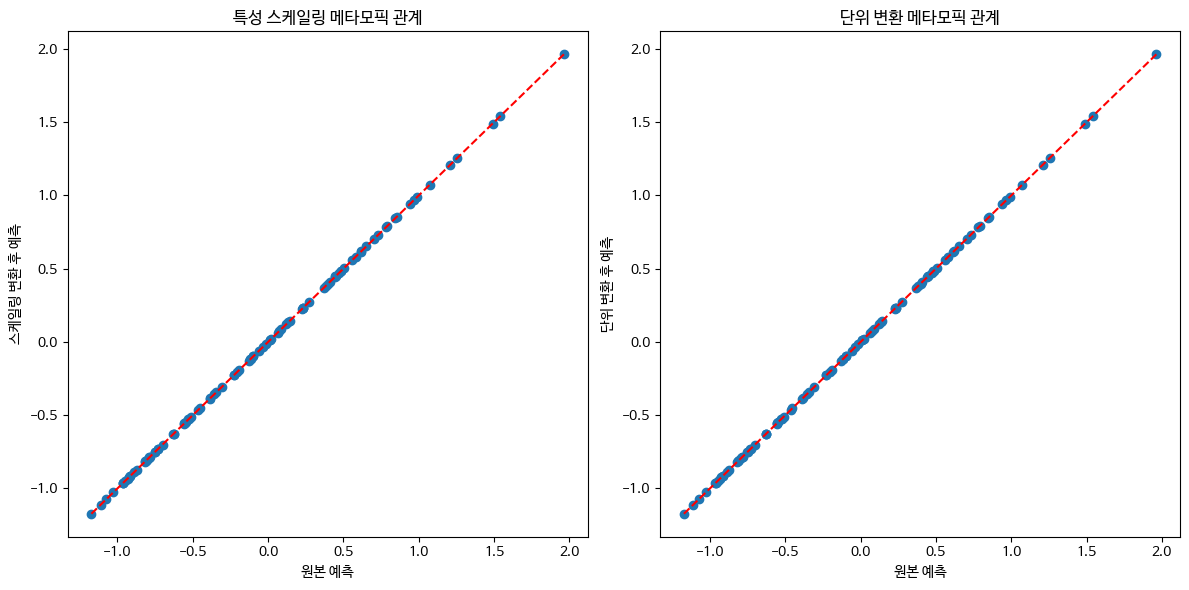

In [111]:
# HouseSales 메타모픽 테스트

print("\nHouseSales 데이터셋 로드 중...")
X_train, X_test, y_train, y_test, feature_names, scaler_X, scaler_y = load_house_data()

print("HouseSales 모델 학습 또는 로드 중...")
# 실제 사용 시에는 학습된 모델을 로드하는 것이 좋습니다
try:
  input_dim = X_train.shape[1]
  house_model = HousePriceModel(input_dim).to(device)
  house_model.load_state_dict(torch.load('model_meta_morphic_house_price_dnn_pytorch.pth', map_location=device))
except:
  print("저장된 모델을 찾을 수 없어 새 모델을 학습합니다.")
  # 간단한 학습 코드
  input_dim = X_train.shape[1]
  house_model = HousePriceModel(input_dim).to(device)

  # 데이터셋 및 데이터로더 생성
  train_dataset = HouseSalesDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

  # 손실 함수와 옵티마이저 정의
  criterion = nn.MSELoss()
  optimizer = optim.Adam(house_model.parameters(), lr=0.001)

  # 간략화된 학습
  for epoch in range(5):
    house_model.train()
    running_loss = 0.0
    for features, targets in train_loader:
      features, targets = features.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = house_model(features)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f'Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}')

  torch.save(house_model.state_dict(), 'model_meta_morphic_house_price_dnn_pytorch.pth')

print("HouseSales 메타모픽 테스트 실행 중...")
house_results = metamorphic_test_house(house_model, X_test, y_test, feature_names, scaler_X)

## **2.3 결과 종합 및 분석**

In [113]:
# 메타모픽 테스트 결과 종합 및 분석
def analyze_metamorphic_test_results(mnist_results, house_results):
    print("\n=== 메타모픽 테스트 종합 결과 ===")

    # MNIST 결과 분석
    rotation_result, brightness_result = mnist_results
    print("MNIST 데이터셋:")
    print(f"  - 회전 변환 일관성: {rotation_result:.4f}")
    print(f"  - 밝기 변경 일관성: {brightness_result:.4f}")

    if rotation_result >= 0.95 and brightness_result >= 0.95:
        print("  ✓ MNIST 모델은 메타모픽 테스트를 통과했습니다!")
    elif rotation_result >= 0.8 and brightness_result >= 0.8:
        print("  △ MNIST 모델은 메타모픽 테스트를 부분적으로 통과했습니다.")
    else:
        print("  ✗ MNIST 모델은 메타모픽 테스트를 통과하지 못했습니다.")

    # HouseSales 결과 분석
    scaling_result, conversion_result = house_results
    print("\nHouseSales 데이터셋:")
    print(f"  - 특성 스케일링 일관성: {scaling_result:.4f}")
    print(f"  - 단위 변환 일관성: {conversion_result:.4f}")

    if scaling_result >= 0.95 and conversion_result >= 0.95:
        print("  ✓ HouseSales 모델은 메타모픽 테스트를 통과했습니다!")
    elif scaling_result >= 0.8 and conversion_result >= 0.8:
        print("  △ HouseSales 모델은 메타모픽 테스트를 부분적으로 통과했습니다.")
    else:
        print("  ✗ HouseSales 모델은 메타모픽 테스트를 통과하지 못했습니다.")

    print("\n메타모픽 테스트 결과 해석:")
    print("1. 일관성 점수가 높을수록 모델이 해당 변환에 강인함을 의미합니다.")
    print("2. 일관성 점수가 낮다면 모델이 해당 변환에 취약하며, 추가 학습이나 데이터 증강이 필요할 수 있습니다.")
    print("3. 메타모픽 테스트는 테스트 오라클 문제를 해결하는 효과적인 방법으로, 모델의 신뢰성을 검증합니다.")

In [114]:
# 종합 결과 분석
analyze_metamorphic_test_results(mnist_results, house_results)


=== 메타모픽 테스트 종합 결과 ===
MNIST 데이터셋:
  - 회전 변환 일관성: 0.9900
  - 밝기 변경 일관성: 0.9800
  ✓ MNIST 모델은 메타모픽 테스트를 통과했습니다!

HouseSales 데이터셋:
  - 특성 스케일링 일관성: 1.0000
  - 단위 변환 일관성: 1.0000
  ✓ HouseSales 모델은 메타모픽 테스트를 통과했습니다!

메타모픽 테스트 결과 해석:
1. 일관성 점수가 높을수록 모델이 해당 변환에 강인함을 의미합니다.
2. 일관성 점수가 낮다면 모델이 해당 변환에 취약하며, 추가 학습이나 데이터 증강이 필요할 수 있습니다.
3. 메타모픽 테스트는 테스트 오라클 문제를 해결하는 효과적인 방법으로, 모델의 신뢰성을 검증합니다.
